In [2]:
import numpy as np
from utilities.Dataset import *
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List



In [8]:
from torcheeg.models import EEGNet
import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)
    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        model= EEGNet_IE_EEG_Wrapper(
            DEVICE, classifier, input_dim[0]
        ).to(DEVICE)

#         train_func= eeg_grad_train
#         model.training_procedure(iteration=n_epochs,
#                                  train_dataloader=train_dataloader,
#                                  val_dataloader=val_dataloader,
#                                  print_cycle=2,
#                                  path=f"./dictionary/intermdiate_dicts",
#                                  loss_func=criterion,
#                                  optimiser=optimizer, #scheduler=scheduler,
#                                  train_func=train_func
#                                 )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_EEG-e{EPOCH}.pt"
#                )
#         )
#         pickle.dump(model.return_IE_grad(),
#                     open(
#                         os.path.join(
#                             saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_EEG-grad_all-e{EPOCH}.pkl"
#                         ), "wb")
#         )
    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_EEG-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )
        model.IE_grad= pickle.load(
                open(
                    os.path.join(
                        saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_EEG-grad_all-e{n_epochs}.pkl"
                    ),"rb"
                )
            )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
    #     participants_grads_dictionary[participants[i]]= model.return_IE_grad()
        participants_dictionary.append(dictionary)
    pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-Grad_EEG.pkl","wb"))
    
   

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


105 21

c0_acc 0.9459459459459459 , c1_acc 0.42 , b_acc 0.682972972972973
112 11

c0_acc 0.9739130434782609 , c1_acc 0.20754716981132076 , b_acc 0.5907301066447909
111 8

c0_acc 0.9024390243902439 , c1_acc 0.1509433962264151 , b_acc 0.5266912103083295
118 11

c0_acc 0.9007633587786259 , c1_acc 0.19642857142857142 , b_acc 0.5485959651035986
109 11

c0_acc 0.9316239316239316 , c1_acc 0.22448979591836735 , b_acc 0.5780568637711495
120 3

c0_acc 0.96 , c1_acc 0.06 , b_acc 0.51
111 17

c0_acc 0.888 , c1_acc 0.30357142857142855 , b_acc 0.5957857142857143
117 8

c0_acc 0.9285714285714286 , c1_acc 0.13559322033898305 , b_acc 0.5320823244552059
128 8

c0_acc 0.9624060150375939 , c1_acc 0.14545454545454545 , b_acc 0.5539302802460697
126 8

c0_acc 0.9767441860465116 , c1_acc 0.13559322033898305 , b_acc 0.5561687031927474
113 7

c0_acc 0.9495798319327731 , c1_acc 0.14583333333333334 , b_acc 0.5477065826330532
119 25

c0_acc 0.9754098360655737 , c1_acc 0.46296296296296297 , b_acc 0.7191863995142683

     accuracy  f1-score
S01  0.770186  0.740146
S02  0.708333  0.631766
S03  0.687500  0.629937
S04  0.705882  0.646371
S05  0.716867  0.672979
S06  0.702857  0.608358
S07  0.718232  0.679856
S08  0.681081  0.612901
S09  0.728723  0.671562
S10  0.702128  0.609767
S11  0.712575  0.638205
S12  0.789773  0.762353
S13  0.726257  0.661325
S14  0.701657  0.606220
S15  0.710383  0.634917
S16  0.715847  0.659226
S17  0.722892  0.674484
S19  0.695652  0.636406
S20  0.772222  0.749079


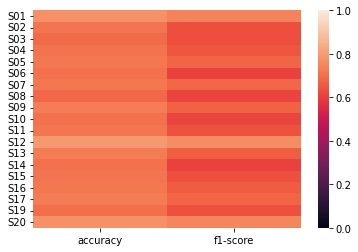

     class0 f1-score  class1 f1-score
S01         0.851406         0.493151
S02         0.820513         0.222222
S03         0.804270         0.225352
S04         0.817276         0.246575
S05         0.821293         0.318841
S06         0.823129         0.071429
S07         0.818505         0.370370
S08         0.800000         0.213333
S09         0.832787         0.281690
S10         0.819355         0.151515
S11         0.826087         0.172414
S12         0.864469         0.531646
S13         0.830450         0.289855
S14         0.820000         0.129032
S15         0.822742         0.208955
S16         0.823129         0.277778
S17         0.825758         0.323529
S19         0.808219         0.263158
S20         0.850909         0.517647


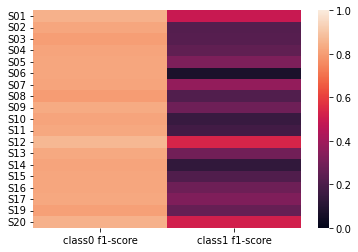

In [9]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [11]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [12]:
participant_grad={"AUC":[],"ROC":[],"STD":[]}
for i in range(len(participants)):
    g= pickle.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Grad_EEG-grad_all-e{n_epochs}.pkl"
                ),"rb"
            )
    )
    
    participant_grad["AUC"].append(
        pd.DataFrame(
            Grad_AUC_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["ROC"].append(
        pd.DataFrame(
            Grad_ROC_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["STD"].append(
        pd.DataFrame(
            Grad_STD_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )

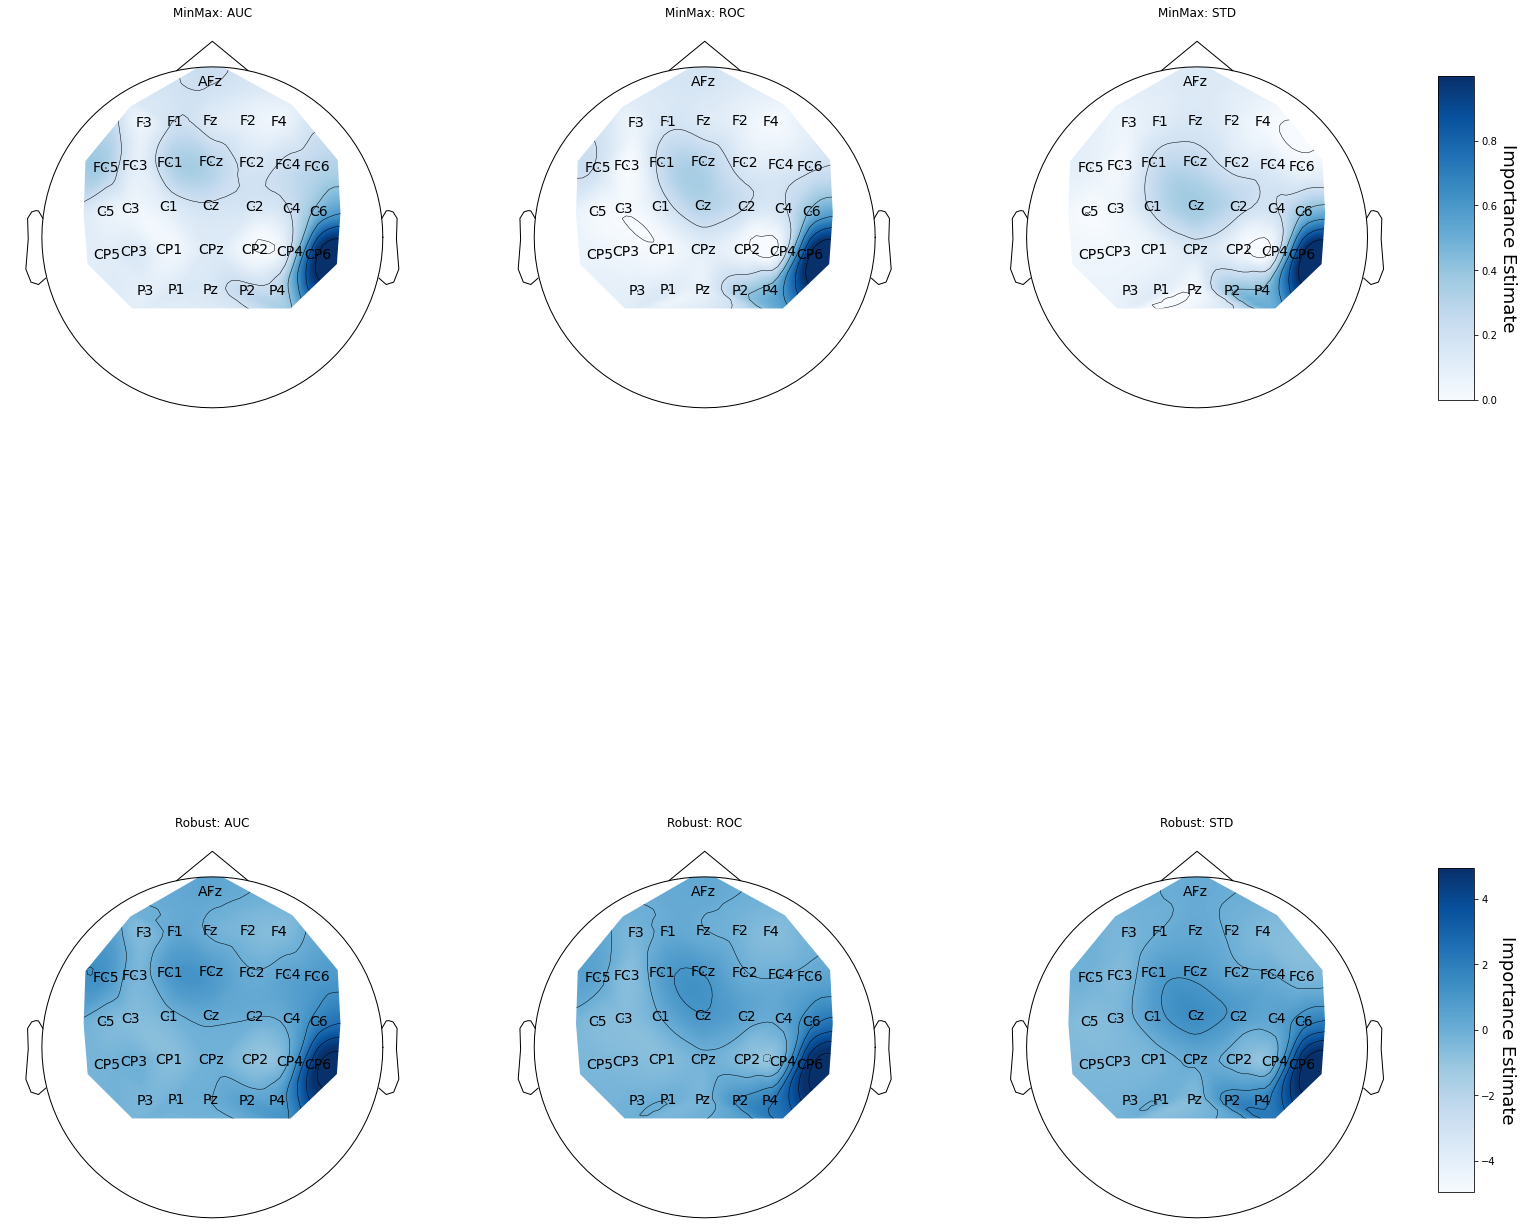

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig, ax= plt.subplots(2,3)
methods=["AUC", "ROC", "STD"]
for idx, i in enumerate(methods):
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(np.array(participant_grad[i]).mean(0).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    minmax_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[0][idx],
        show=False,
        extrapolate="local"
        #,vlim=(0,1)
    #     sphere=0.09
    )
    ax[0][idx].set_title(f"MinMax: {i}")
    
for idx, i in enumerate(methods):
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(np.array(participant_grad[i]).mean(0).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    robust_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[1][idx],
        show=False,
        extrapolate="local",
#         vlim=(0,None)
    #     sphere=0.09
    )
    ax[1][idx].set_title(f"Robust: {i}")
    
fig.set_figheight(25)
fig.set_figwidth(25)

cbar_ax= fig.add_axes([.92,0.66, 0.02,0.18])
clb= fig.colorbar(minmax_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

cbar_ax= fig.add_axes([.92,0.22, 0.02,0.18])
clb= fig.colorbar(robust_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)
